# Sohil Malik

# QMSS 5074

# Assignment 1

Link to public Github repo: https://github.com/sm5271/QMSS5074.git

In [43]:
#install aimodelshare library
! pip install aimodelshare --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [44]:
#Get competition data from course folder and unzip
# importing the zipfile module
from zipfile import ZipFile
  
# loading the temp.zip and creating a zip object
with ZipFile("world_happiness_competition_data.zip", 'r') as zObject:
  
    # Extracting all the members of the zip 
    # into a specific location.
    zObject.extractall()

In [45]:
# Load data
import pandas as pd
X_train = pd.read_csv('world_happiness_competition_data/X_train.csv')
X_test = pd.read_csv('world_happiness_competition_data/X_test.csv')
y_train = pd.read_csv('world_happiness_competition_data/y_train.csv')
y_train_labels = y_train.idxmax(axis=1)

X_train.head()

,Country or region,GDP per capita,Social support,Healthy life expectancy,Freedom to make life choices,Generosity,Perceptions of corruption,name,region,sub-region,Terrorist_attacks
0,Peru,0.960,1.274,0.854,0.455,0.083,0.027,Peru,Americas,Latin America and the Caribbean,18.000000
1,Nicaragua,0.694,1.325,0.835,0.435,0.200,0.127,Nicaragua,Americas,Latin America and the Caribbean,125.611111
2,Greece,1.181,1.156,0.999,0.067,0.000,0.034,Greece,Europe,Southern Europe,112.000000
3,Qatar,1.684,1.313,0.871,0.555,0.220,0.167,Qatar,Asia,Western Asia,57.333333
4,Uzbekistan,0.745,1.529,0.756,0.631,0.322,0.240,Uzbekistan,Asia,Central Asia,125.611111


**Part 1**

Based on the visualizations below, it can be seen that countries with very high reports of happiness have greater GDP per capita as well as higher healthy life expectancy.

In [46]:
from matplotlib import pyplot as plt 

Text(0, 0.5, 'Happiness Label')

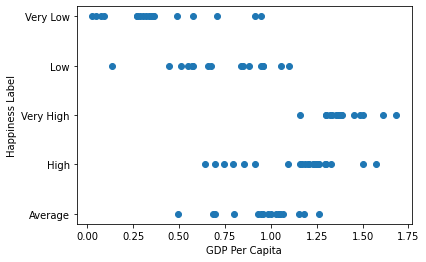

In [47]:
plt.scatter(X_train['GDP per capita'], y_train_labels)
plt.xlabel("GDP Per Capita")
plt.ylabel("Happiness Label")

Text(0, 0.5, 'Happiness Label')

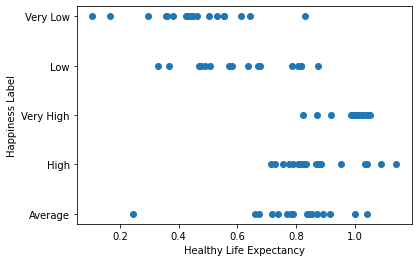

In [48]:
plt.scatter(X_train['Healthy life expectancy'], y_train_labels)
plt.xlabel("Healthy Life Expectancy")
plt.ylabel("Happiness Label")

**Part 2**

As per the visualization below, GDP per capita and healthy life expectancy are some of the most important features.

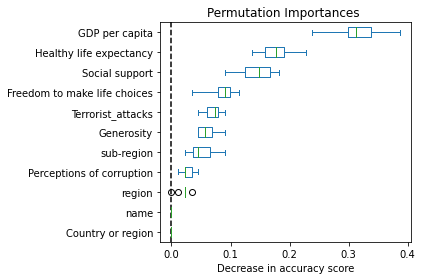

In [91]:
from sklearn.inspection import permutation_importance

rf = Pipeline([
    ('preprocess', preprocess),
    # put your model below
    ('classifier', RandomForestClassifier(random_state=42))
])

rf.fit(X_train, y_train)

result = permutation_importance(rf, X_train, y_train, n_repeats=10,
                                random_state=42, n_jobs=2)

sorted_importances_idx = result.importances_mean.argsort()
importances = pd.DataFrame(
    result.importances[sorted_importances_idx].T,
    columns=X_train.columns[sorted_importances_idx],
)
ax = importances.plot.box(vert=False, whis=10)
ax.set_title("Permutation Importances ")
ax.axvline(x=0, color="k", linestyle="--")
ax.set_xlabel("Decrease in accuracy score")
ax.figure.tight_layout()

**Part 3**

Prior to communicating with my team, I chose to create three random forest classifier models. The third model incorporates grid search CV to test for different parameters.

In [49]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# We create the preprocessing pipelines for both numeric and categorical data.

numeric_features = X_train.drop(['Country or region', 'name', 'region', 'sub-region'], axis=1)
numeric_features=numeric_features.columns.tolist()

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_features = ['region', 'sub-region']

#Replacing missing values with Modal value and then one hot encoding.
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# final preprocessor object set up with ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

#Fit your preprocessor object
preprocess=preprocessor.fit(X_train) 

In [50]:
# Write function to transform data with preprocessor

def preprocessor(data):
    data.drop(['Country or region', 'name'], axis=1)
    preprocessed_data=preprocess.transform(data)
    return preprocessed_data

In [51]:
# check shape of X data after preprocessing
preprocessor(X_train).shape

(88, 26)

In [52]:
# Train Model 1

from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=500, max_depth=3)
model.fit(preprocessor(X_train), y_train_labels) # Fitting to the training set.
model.score(preprocessor(X_train), y_train_labels) # Fit score, 0-1 scale.

0.8636363636363636

In [53]:
import aimodelshare as ai
ai.export_preprocessor(preprocessor,"") 

Your preprocessor is now saved to 'preprocessor.zip'


In [54]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

# Check how many preprocessed input features are there?
from skl2onnx.common.data_types import FloatTensorType

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  #Insert correct number of preprocessed features

onnx_model = model_to_onnx(model, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [16]:
#Set credentials using modelshare.org username/password

from aimodelshare.aws import set_credentials

#This is the unique rest api that powers this World Happiness Classification Playground -- make sure to update the apiurl for new competition deployments
apiurl="https://e2w6gh3id1.execute-api.us-east-2.amazonaws.com/prod/m"

set_credentials(apiurl=apiurl)

AI Modelshare Username:··········
AI Modelshare Password:··········
AI Model Share login credentials set successfully.


In [17]:
#Instantiate Competition
import aimodelshare as ai
mycompetition= ai.Competition(apiurl)

In [ ]:
#Submit Model 1: 

#-- Generate predicted values (Model 1)
prediction_labels = model.predict(preprocessor(X_test))

# Submit Model 1 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                                 custom_metadata={"team":"1"})

Insert search tags to help users find your model (optional): sm_5271
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 573

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [ ]:
# Train Model 2
from sklearn.ensemble import RandomForestClassifier

model_2 = RandomForestClassifier(n_estimators=200, max_depth=5)
model_2.fit(preprocessor(X_train), y_train_labels) # Fitting to the training set.
model_2.score(preprocessor(X_train), y_train_labels) # Fit score, 0-1 scale.

0.9659090909090909

In [ ]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  # Insert correct number of preprocessed features

onnx_model = model_to_onnx(model_2, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model2.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [ ]:
#Submit Model 2: 

#-- Generate predicted y values (Model 2)
prediction_labels = model_2.predict(preprocessor(X_test))

# Submit Model 2 to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model2.onnx",
                                 prediction_submission=prediction_labels,
                                 preprocessor_filepath="preprocessor.zip",
                                 custom_metadata={"team":"1"})

Insert search tags to help users find your model (optional): sm_5271
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 577

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [77]:
# Submit a third model using GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

param_grid = {'n_estimators': np.arange(100, 300, 500),'max_depth':[1, 3, 5]} #np.arange creates sequence of numbers for each k value

gridmodel = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=10)

#use meta model methods to fit score and predict model:
gridmodel.fit(preprocessor(X_train), y_train_labels)

#extract best score and parameter by calling objects "best_score_" and "best_params_"
print("best mean cross-validation score: {:.3f}".format(gridmodel.best_score_))
print("best parameters: {}".format(gridmodel.best_params_))


best mean cross-validation score: 0.649
best parameters: {'max_depth': 3, 'n_estimators': 100}


In [79]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  # Insert correct number of preprocessed features

onnx_model = model_to_onnx(gridmodel, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("gridmodel.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [80]:
#Submit Model 3: 

#-- Generate predicted values
prediction_labels = gridmodel.predict(preprocessor(X_test))

# Submit to Competition Leaderboard
mycompetition.submit_model(model_filepath = "gridmodel.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                                 custom_metadata={"team":"1"})

Insert search tags to help users find your model (optional): sm_5271
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 815

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


While discussing models with my team, I learned that my team members also utilized random forest classifier models. In addition to random forests, they tried gradient boosting. For my final three models, I used both random forests and gradient boosting. 

Out of all of my models, the one that scored the highest on the leaderboard used a random forest classifier with n_estimators=200 and  max_depth=5. 

In [62]:
# Train Model 4

model4 = RandomForestClassifier(n_estimators=250, max_depth=3)
model4.fit(preprocessor(X_train), y_train_labels) # Fitting to the training set.
model4.score(preprocessor(X_train), y_train_labels) # Fit score, 0-1 scale.

0.8522727272727273

In [63]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

# Check how many preprocessed input features are there?
from skl2onnx.common.data_types import FloatTensorType

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  #Insert correct number of preprocessed features

onnx_model = model_to_onnx(model4, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model4.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [64]:
#Submit Model 4: 

#-- Generate predicted values (Model 4)
prediction_labels = model4.predict(preprocessor(X_test))

# Submit Model to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model4.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                                 custom_metadata={"team":"1"})

Insert search tags to help users find your model (optional): sm_5271
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 810

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [82]:
# Train Model 5

model4 = RandomForestClassifier(n_estimators=350, max_depth=5)
model4.fit(preprocessor(X_train), y_train_labels) # Fitting to the training set.
model4.score(preprocessor(X_train), y_train_labels) # Fit score, 0-1 scale.

0.9431818181818182

In [83]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

# Check how many preprocessed input features are there?
from skl2onnx.common.data_types import FloatTensorType

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  #Insert correct number of preprocessed features

onnx_model = model_to_onnx(model4, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model4.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [84]:
#Submit Model 5: 

#-- Generate predicted values (Model 5)
prediction_labels = model4.predict(preprocessor(X_test))

# Submit Model to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model4.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                                 custom_metadata={"team":"1"})

Insert search tags to help users find your model (optional): sm_5271
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 823

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [85]:
# Train Model 6

from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(n_estimators=50, learning_rate=0.1,
                                   max_depth=1, random_state=0).fit(preprocessor(X_train), y_train_labels)
model.score(preprocessor(X_train), y_train_labels)

0.9090909090909091

In [86]:
# Save sklearn model to local ONNX file
from aimodelshare.aimsonnx import model_to_onnx

# Check how many preprocessed input features are there?
from skl2onnx.common.data_types import FloatTensorType

feature_count=preprocessor(X_test).shape[1] #Get count of preprocessed features
initial_type = [('float_input', FloatTensorType([None, feature_count]))]  #Insert correct number of preprocessed features

onnx_model = model_to_onnx(model, framework='sklearn',
                          initial_types=initial_type,
                          transfer_learning=False,
                          deep_learning=False)

with open("model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())

In [87]:
#Submit Model 6: 

#-- Generate predicted values 
prediction_labels = model.predict(preprocessor(X_test))

# Submit Model to Competition Leaderboard
mycompetition.submit_model(model_filepath = "model.onnx",
                                 preprocessor_filepath="preprocessor.zip",
                                 prediction_submission=prediction_labels,
                                 custom_metadata={"team":"1"}) 

Insert search tags to help users find your model (optional): sm_5271
Provide any useful notes about your model (optional): 

Your model has been submitted as model version 824

To submit code used to create this model or to view current leaderboard navigate to Model Playground: 

 https://www.modelshare.org/detail/model:3164


In [88]:
# Get leaderboard to explore current best model architectures

# Get raw data in pandas data frame
data = mycompetition.get_leaderboard()

# Stylize leaderboard data
mycompetition.stylize_leaderboard(data)